In [28]:
import sys

import uproot # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import tensorflow as tf
from tensorflow import keras

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import functions

# Page 6

In [29]:
df = pd.read_pickle('data.pkl')
df_train = df.iloc[0:800000]
df_test = df.iloc[800000::]

In [37]:
df.head()

,lep_n,lep_pt,lep_eta,lep_phi,lep_E,lep_charge,lep_type,lep_ptcone30,lep_etcone20,totalWeight,mllll,lep_pt_1,lep_pt_2,type
entry,,,,,,,,,,,,,,
122184,4,"[115386.75, 68327.055, 55912.14, 46289.973]","[-2.4141972, -1.7635455, -2.0611405, -1.8641573]","[-0.91232985, 1.2147496, 2.8340168, -2.1358066]","[650217.6, 205135.52, 223151.84, 152884.78]","[1, 1, -1, -1]","[11, 11, 11, 11]","[0.0, 0.0, 0.0, 0.0]","[1861.3513, 2816.224, 1838.1691, 368.9771]",0.001820,292.304140,68.327055,55.912141,0
45301,4,"[52015.19, 16996.518, 11595.154, 8811.983]","[-0.92903495, -0.46927732, -1.1208072, -0.1817...","[-0.28204682, -2.7520332, 2.8016145, 3.1268525]","[76124.28, 18902.908, 19673.467, 8958.624]","[-1, 1, -1, 1]","[13, 13, 13, 13]","[0.0, 0.0, 0.0, 0.0]","[823.22644, 176.19177, 371.786, -831.1925]",0.001663,90.419489,16.996518,11.595154,0
99430,4,"[59973.15, 42322.973, 13036.398, 9584.969]","[-1.4100251, -2.1813457, -2.198997, -1.236703]","[1.9874572, -2.1674008, -0.12135019, 1.7154149]","[130147.63, 189842.02, 59490.918, 17898.225]","[-1, 1, -1, 1]","[13, 13, 13, 13]","[0.0, 1553.7449, 0.0, 0.0]","[-214.75171, -70.97525, 1841.9778, -115.00061]",0.000077,127.022912,42.322973,13.036398,1
167953,4,"[52327.11, 50149.164, 39719.863, 36806.33]","[1.0194854, -0.6720537, -0.27007684, 0.6950957]","[-2.2804918, -1.2961419, 2.0781178, 1.0791849]","[81958.67, 61906.977, 41177.305, 46061.906]","[-1, 1, -1, 1]","[13, 11, 11, 13]","[0.0, 0.0, 0.0, 0.0]","[-1017.5383, -42.100677, 4.2281494, -452.41992]",0.000200,224.881655,50.149164,39.719863,0
24358,4,"[71476.64, 49188.074, 10618.092, 10553.615]","[-0.8086124, -1.465419, -0.35426486, -1.9112123]","[2.1955068, -2.5806403, -0.70600003, 1.9758896]","[96145.67, 112157.18, 11291.394, 36458.42]","[1, -1, -1, 1]","[13, 13, 11, 11]","[1169.696, 0.0, 0.0, 0.0]","[682.84155, -1131.4159, -670.21173, 839.6236]",0.000003,128.408689,49.188074,10.618092,1


In [41]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Specify columns used for training
num_attribs = ['lep_pt_1', 'lep_pt_2', 'mllll']
full_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler())
])


X_train = full_pipeline.fit_transform(df_train)
y_train = df_train['type'].values

X_test = full_pipeline.transform(df_test)
y_test = df_test['type'].values

X_train

array([[ 0.57023955,  1.36370524,  0.77279159],
       [-1.00792607, -0.99984536, -0.81445341],
       [-0.22926013, -0.92297972, -0.52667224],
       ...,
       [-0.27820319,  0.33155839, -0.55409991],
       [ 2.01216741, -0.69342999, -0.55136036],
       [-0.52985323, -0.23842974, -0.54466061]])

# Page 7

Now prepare data for neural network binary classifier.

In [42]:
RF_clf = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=30)
RF_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
y_pred = RF_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9708020878444601


Neural network

In [44]:
def build_model(n_hidden=1, n_neurons=5, learning_rate=1e-3):
    # Build
    model = keras.models.Sequential()
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(2, activation='softmax'))
    # Compile
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

X_valid, X_train_nn = X_train[:700000], X_train[700000:]
y_valid, y_train_nn = y_train[:700000], y_train[700000:]

NN_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)
NN_clf.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Train on 800000 samples, validate on 700000 samples
Epoch 1/5
800000/800000 [==============================] - 30s 37us/sample - loss: 0.4536 - accuracy: 0.8143 - val_loss: 0.3719 - val_accuracy: 0.8575
Epoch 2/5
800000/800000 [==============================] - 31s 38us/sample - loss: 0.3437 - accuracy: 0.8617 - val_loss: 0.3245 - val_accuracy: 0.8637
Epoch 3/5
800000/800000 [==============================] - 30s 37us/sample - loss: 0.3134 - accuracy: 0.8640 - val_loss: 0.3050 - val_accuracy: 0.8643
Epoch 4/5
800000/800000 [==============================] - 30s 37us/sample - loss: 0.2988 - accuracy: 0.8644 - val_loss: 0.2927 - val_accuracy: 0.8647
Epoch 5/5
800000/800000 [==============================] - 29s 37us/sample - loss: 0.2859 - accuracy: 0.8645 - val_loss: 0.2784 - val_accuracy: 0.8642


# Page 8

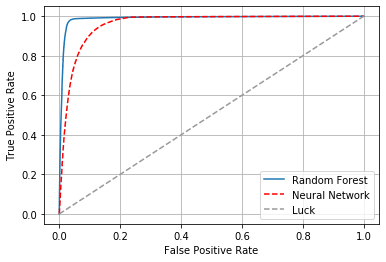

In [48]:
decisions_nn = NN_clf.predict_proba(X_test)[:,1]
decisions_rf = RF_clf.predict_proba(X_test)[:,1]
fpr_nn, tpr_nn, thresholds = roc_curve(y_test, decisions_nn)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, decisions_rf)

plt.plot(fpr_rf,tpr_rf, label='Random Forest')
plt.plot(fpr_nn,tpr_nn, color='r', ls='--', label='Neural Network')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.grid()
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()